
# **Starbucks Stock Price Prediction using Deep Neural Networks**

.

## **LOAD LIBRARIES/DEPENDENCIES**

In [ ]:
!pip install holidays
!pip install keras-tuner

import os
import math
import random
import holidays
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Permute, Lambda, Multiply
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv1D, Attention, Input, Flatten
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, BatchNormalization, SpatialDropout1D, Dense, Dropout, Concatenate, Multiply, Lambda, GlobalAveragePooling1D, GlobalMaxPooling1D

Necessary Libraries have been loaded

In [ ]:
# Set seed for random modules
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

.

## **LOAD DATA (Starbucks, 2017 TO 2025)**

In [ ]:
data = pd.read_csv('/content/starbucks_open_7year.csv')

Starbucks data loaded

## **VIEW DATA (Starbucks)**

In [ ]:
data

,Unnamed: 0,Date,Open,Time
0,0,11/13/2017,56.81,1.510531e+09
1,1,11/14/2017,56.47,1.510618e+09
2,2,11/15/2017,56.82,1.510704e+09
3,3,11/16/2017,56.92,1.510790e+09
4,4,11/17/2017,57.24,1.510877e+09
...,...,...,...,...
1795,1795,01/03/2025,92.40,1.735862e+09
1796,1796,01/06/2025,92.04,1.736122e+09
1797,1797,01/07/2025,92.78,1.736208e+09
1798,1798,01/08/2025,92.97,1.736294e+09


The starbucks dataset has 4 features namely; **Unnamed: 0**, **Date**, **Open**, and **Time**
- Unnamed: 0 is the row index (numbering).
- Date is the day, month, and year on which the specified Open starbucks price was recorded.
- Open is the opening price of the starbucks stockprice on the specified date.
- Time is the specific time at which the Open starbucks stockprice was recorded.

In [ ]:
# view last 5 rows
data.tail()

,Unnamed: 0,Date,Open,Time
1795,1795,01/03/2025,92.40,1.735862e+09
1796,1796,01/06/2025,92.04,1.736122e+09
1797,1797,01/07/2025,92.78,1.736208e+09
1798,1798,01/08/2025,92.97,1.736294e+09
1799,1799,01/10/2025,92.19,1.736467e+09


In [ ]:
# View feature types
data.dtypes

,0
Unnamed: 0,int64
Date,object
Open,float64
Time,float64


Since we are going to do date-based operations, we will convert the date column to a datetime type

In [ ]:
# View descriptive statistics
data.describe()

,Unnamed: 0,Open,Time
count,1800.00000,1800.000000,1.800000e+03
mean,899.50000,86.827436,1.623458e+09
std,519.75956,17.851747,6.518828e+07
min,0.00000,48.080000,1.510531e+09
25%,449.75000,75.067500,1.567015e+09
50%,899.50000,88.630000,1.623499e+09
75%,1349.25000,99.355000,1.679897e+09
max,1799.00000,126.080000,1.736467e+09


#### **Observations**
- There are 1800 enteries from 2017 to 2025
- Q1 (25th percentile): 25% of the stock prices are below £75.07.
- Median (50th percentile): The middle value (£88.63), meaning half of the opening prices were below this level.
- Q3 (75th percentile): 75% of the prices were below £99.35.
- Mean (86.83): This is the average opening stock from 2017 to 2025.


#### **Insights Gotten from Observations**

- The mean (£86.83) and median (£88.63) are close, suggesting that the distribution of the open starbuck prices from 2017 to 2025 is roughly symmetrical.
- The standard deviation of £17.85 shows that stock prices had moderate fluctuations around the mean within the specified period of 2017 to 2025.
- The min (£48.08) and max (£126.08) show that the stock experienced both lows and highs between 2017 and 2025
- Most prices fell between £75.07 (Q1) and £99.35 (Q3), meaning the majority of stock prices hovered in this range from 2017 to 2025.

.

# **DATA PREPROCESSING**

## **1. Check for missing values**

In [ ]:
data.isnull().sum()

,0
Unnamed: 0,0
Date,0
Open,0
Time,0


There are no missing values

## **2. Convert the 'Date' column to datetime format and check for Duplicate and Missing Dates**

### **a. Duplicate Dates and Rows**

In [ ]:
#---------------------Convert Date column to Datetime format--------------------

data['Date'] = pd.to_datetime(data['Date'])
print("Data type of 'Date' column:", data['Date'].dtype)

#------------------------Sort Data by Date column-------------------------------

data = data.sort_values(by=['Date'])

#----------------------Check for Duplicated Dates-------------------------------

duplicates = data[data.duplicated(subset='Date', keep=False)]
print("Duplicate rows based on the 'Date' column:") #Print the duplicate rows
print(duplicates)

Data type of 'Date' column: datetime64[ns]
Duplicate rows based on the 'Date' column:
Empty DataFrame
Columns: [Unnamed: 0, Date, Open, Time]
Index: []



*   There are no duplicate Dates

### **b. Missing Dates**

In [ ]:
#-----------------------Let's check for missing Dates in Data-------------------

# find date range in data
min_date = data['Date'].min()
max_date = data['Date'].max()
print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

# create complete data range from min to max date
all_dates = pd.date_range(min_date, max_date, freq='D')

# compare with the 'Date' column to find missing dates
missing_dates = all_dates.difference(data['Date'])

# print missing dates
print(f"Missing dates: {missing_dates}")

Minimum date: 2017-11-13 00:00:00
Maximum date: 2025-01-10 00:00:00
Missing dates: DatetimeIndex(['2017-11-18', '2017-11-19', '2017-11-23', '2017-11-25',
               '2017-11-26', '2017-12-02', '2017-12-03', '2017-12-09',
               '2017-12-10', '2017-12-16',
               ...
               '2024-12-15', '2024-12-21', '2024-12-22', '2024-12-25',
               '2024-12-28', '2024-12-29', '2025-01-01', '2025-01-04',
               '2025-01-05', '2025-01-09'],
              dtype='datetime64[ns]', length=816, freq=None)



*   Let's find out if these missing Dates correspond to weekends and Holidays when Stocks are NOT Being TRADED (when the stock market is closed).


In [ ]:
#------------Let's check for missing dates that are Weekends--------------------

# 5 and 6 correspond to Saturday and Sunday
weekends = missing_dates[missing_dates.weekday >= 5]
print(f"Missing weekend dates: {weekends}")

#------------Let's check for missing Dates that are Holidays--------------------

us_holidays = holidays.US(years=range(2017, 2026))
us_holidays_dates = pd.to_datetime(list(us_holidays.keys()))

holiday_dates = missing_dates[missing_dates.isin(us_holidays_dates)]
print(f"Missing holiday dates: {holiday_dates}")

Missing weekend dates: DatetimeIndex(['2017-11-18', '2017-11-19', '2017-11-25', '2017-11-26',
               '2017-12-02', '2017-12-03', '2017-12-09', '2017-12-10',
               '2017-12-16', '2017-12-17',
               ...
               '2024-12-07', '2024-12-08', '2024-12-14', '2024-12-15',
               '2024-12-21', '2024-12-22', '2024-12-28', '2024-12-29',
               '2025-01-04', '2025-01-05'],
              dtype='datetime64[ns]', length=746, freq=None)
Missing holiday dates: DatetimeIndex(['2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03',
               '2018-11-11', '2018-11-22', '2018-12-25', '2019-01-01',
               '2019-01-21', '2019-02-18', '2019-05-27', '2019-07-04',
               '2019-09-02', '2019-11-28', '2019-12-25', '2020-01-01',
               '2020-01-20', '2020-02-17', '2020-05-25', '2020-07-03',
               '2020-07-04', '2020-09-07', '2020-11-26', '2020-12-25',
      

In [ ]:
#-------Identify missing dates that are neither weekends nor holidays-----------
non_weekend_holiday_dates = missing_dates[~missing_dates.isin(weekends) & ~missing_dates.isin(us_holidays_dates)]

#-------------Print the dates and their corresponding weekdays------------------
for date in non_weekend_holiday_dates:
    weekday = date.strftime("%A")
    print(f"{date.date()}: {weekday}", end="")

2018-03-30: Friday2018-12-05: Wednesday2019-04-19: Friday2020-04-10: Friday2021-04-02: Friday2022-04-15: Friday2023-04-07: Friday2024-03-29: Friday2025-01-09: Thursday

*   **NB**: Most missing dates are on a Friday. Since Stock Trading does not occur on Good Fridays in the US, and Good Friday is not included in the Holidays calendar, we will now check if these possible missing dates are Good Fridays.

In [ ]:
#------------Check if missing dates are Good Friday Dates-----------------------
def good_friday_dates(start_year, end_year):
    """Generates Good Friday dates between start_year and end_year (inclusive)."""
    good_friday_dates = []
    for year in range(start_year, end_year + 1):
        # Easter Sunday calculation (Meeus/Jones/Butcher algorithm)
        a = year % 19
        b = year // 100
        c = year % 100
        d = b // 4
        e = b % 4
        f = (b + 8) // 25
        g = (b - f + 1) // 3
        h = (19 * a + b - d - g + 15) % 30
        i = c // 4
        k = c % 4
        l = (32 + 2 * e + 2 * i - h - k) % 7
        m = (a + 11 * h + 22 * l) // 451
        month = (h + l - 7 * m + 114) // 31
        day = ((h + l - 7 * m + 114) % 31) + 1
        easter_sunday = datetime.date(year, month, day)

        # Good Friday is 2 days before Easter Sunday
        good_friday = easter_sunday - datetime.timedelta(days=2)
        good_friday_dates.append(good_friday)
    return good_friday_dates


# Generate Good Friday dates between 2017 and 2025
good_friday_dates_list = good_friday_dates(2017, 2025)
good_friday_dates_series = pd.to_datetime(good_friday_dates_list)

# Check if any of the non_weekend_holiday_dates are Good Friday dates
good_friday_missing_dates = non_weekend_holiday_dates[
    non_weekend_holiday_dates.isin(good_friday_dates_series)
]

print("Missing dates that are Good Fridays:", good_friday_missing_dates)

Missing dates that are Good Fridays: DatetimeIndex(['2018-03-30', '2019-04-19', '2020-04-10', '2021-04-02',
               '2022-04-15', '2023-04-07', '2024-03-29'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
# Identify remaining missing dates (excluding weekends, holidays, and Good Friday)
remaining_missing_dates = missing_dates[
    ~missing_dates.isin(weekends) &
    ~missing_dates.isin(us_holidays_dates) &
    ~missing_dates.isin(good_friday_dates_series)
]

print("Remaining missing dates:", remaining_missing_dates)

Remaining missing dates: DatetimeIndex(['2018-12-05', '2025-01-09'], dtype='datetime64[ns]', freq=None)


*   If we keep aside Weekends, Holidays, and Good Fridays when stocks are not traded, we have 2 missing dates from our dataset. Since we can not verify if the data for these 2 days are truly missing or if stock was not traded on those days, we will keep them aside rather than implementing forward or backward filling or interpolation. This will be one of the limitations of our models.

.

# **EXPLORATORY DATA ANALYSIS**

## **1. Check for Outliers and Anomalies in Open price using the IQR method for Outlier Detection**

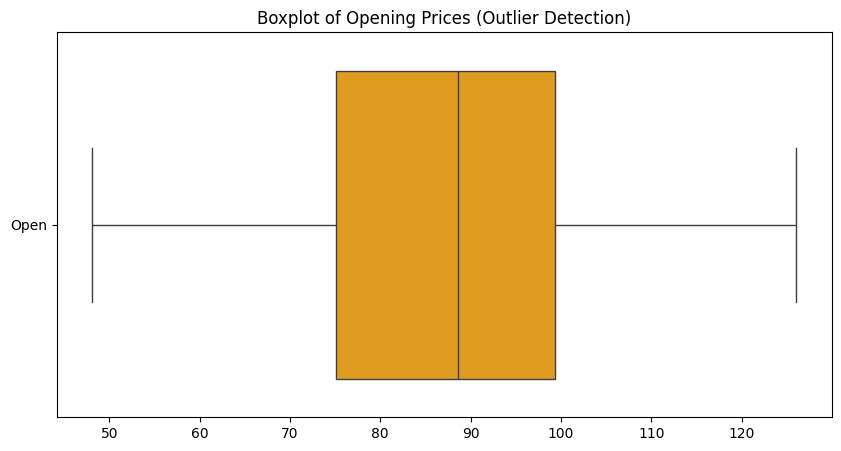

In [ ]:
#---------------------checking for outliers-------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[["Open"]], orient="h", color="orange")
plt.title("Boxplot of Opening Prices (Outlier Detection)")
plt.show()

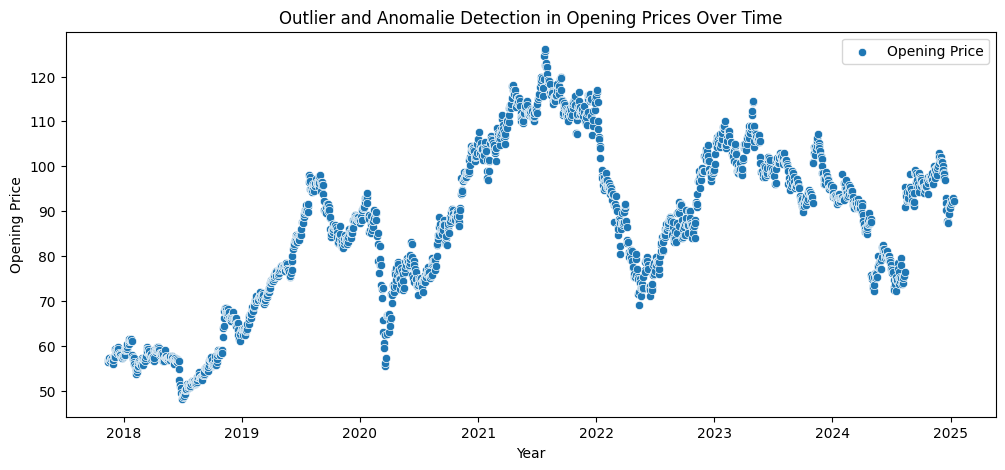

Number of outliers: 0


In [ ]:
#---------------Identify potential outliers using IQR method--------------------

Q1 = data["Open"].quantile(0.25)
Q3 = data["Open"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = data[(data["Open"] < lower_bound) | (data["Open"] > upper_bound)]

# Visualize outliers on a scatter plot
plt.figure(figsize=(12, 5))
sns.scatterplot(x=data["Date"], y=data["Open"], label="Opening Price")
sns.scatterplot(x=outliers["Date"], y=outliers["Open"], color="red", label="Outliers", marker="o")
plt.title("Outlier and Anomalie Detection in Opening Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Opening Price")
plt.legend()
plt.show()

print("Number of outliers:", len(outliers))


*   There are NO outliers
*  No anomalies have been observed


## **2. Analysing Trends**

### **a. Yearly Trend of StarBucks Open Price (2017 to 2025)**

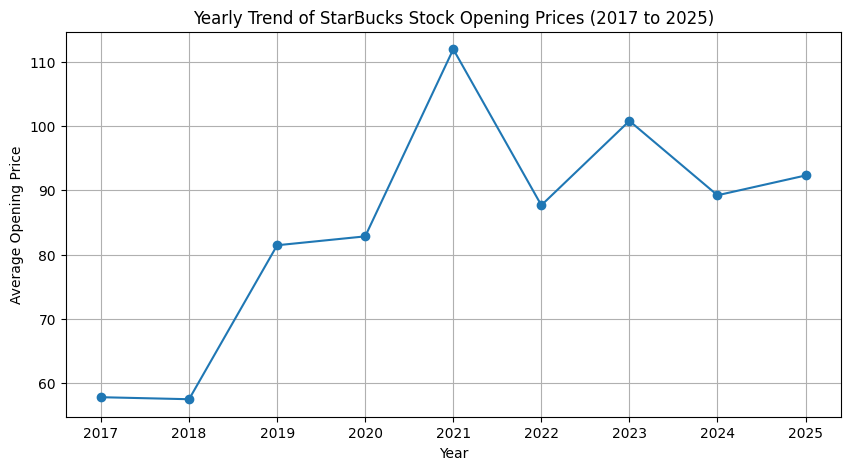

In [ ]:
# Extract year and month for trend analysis
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month

# Yearly trend visualization
plt.figure(figsize=(10, 5))
data.groupby("Year")["Open"].mean().plot(marker="o", linestyle="-")
plt.title("Yearly Trend of StarBucks Stock Opening Prices (2017 to 2025)")
plt.xlabel("Year")
plt.ylabel("Average Opening Price")
plt.grid(True)
plt.show()

### **b. Monthly Trend of StarBucks Open Price for each Year (2017 to 2025)**

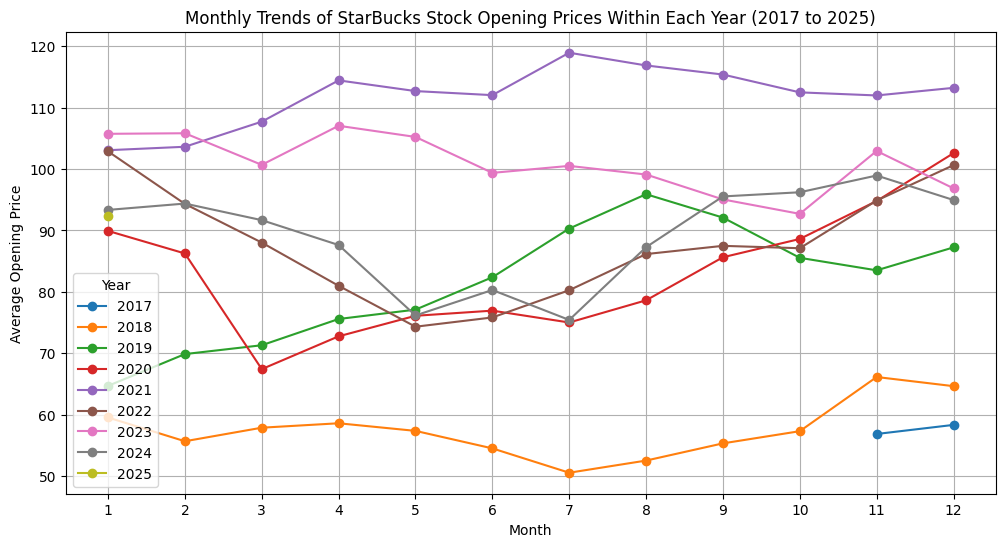

In [ ]:
# Group by year and month, then calculate the mean opening price
monthly_trends = data.groupby(["Year", "Month"])["Open"].mean().unstack(level=0)

# Plot monthly trends for each year
plt.figure(figsize=(12, 6))
for year in monthly_trends.columns:
    plt.plot(monthly_trends.index, monthly_trends[year], marker="o", label=str(year))

plt.title("Monthly Trends of StarBucks Stock Opening Prices Within Each Year (2017 to 2025)")
plt.xlabel("Month")
plt.ylabel("Average Opening Price")
plt.xticks(range(1, 13))
plt.legend(title="Year", loc="best")
plt.grid(True)
plt.show()

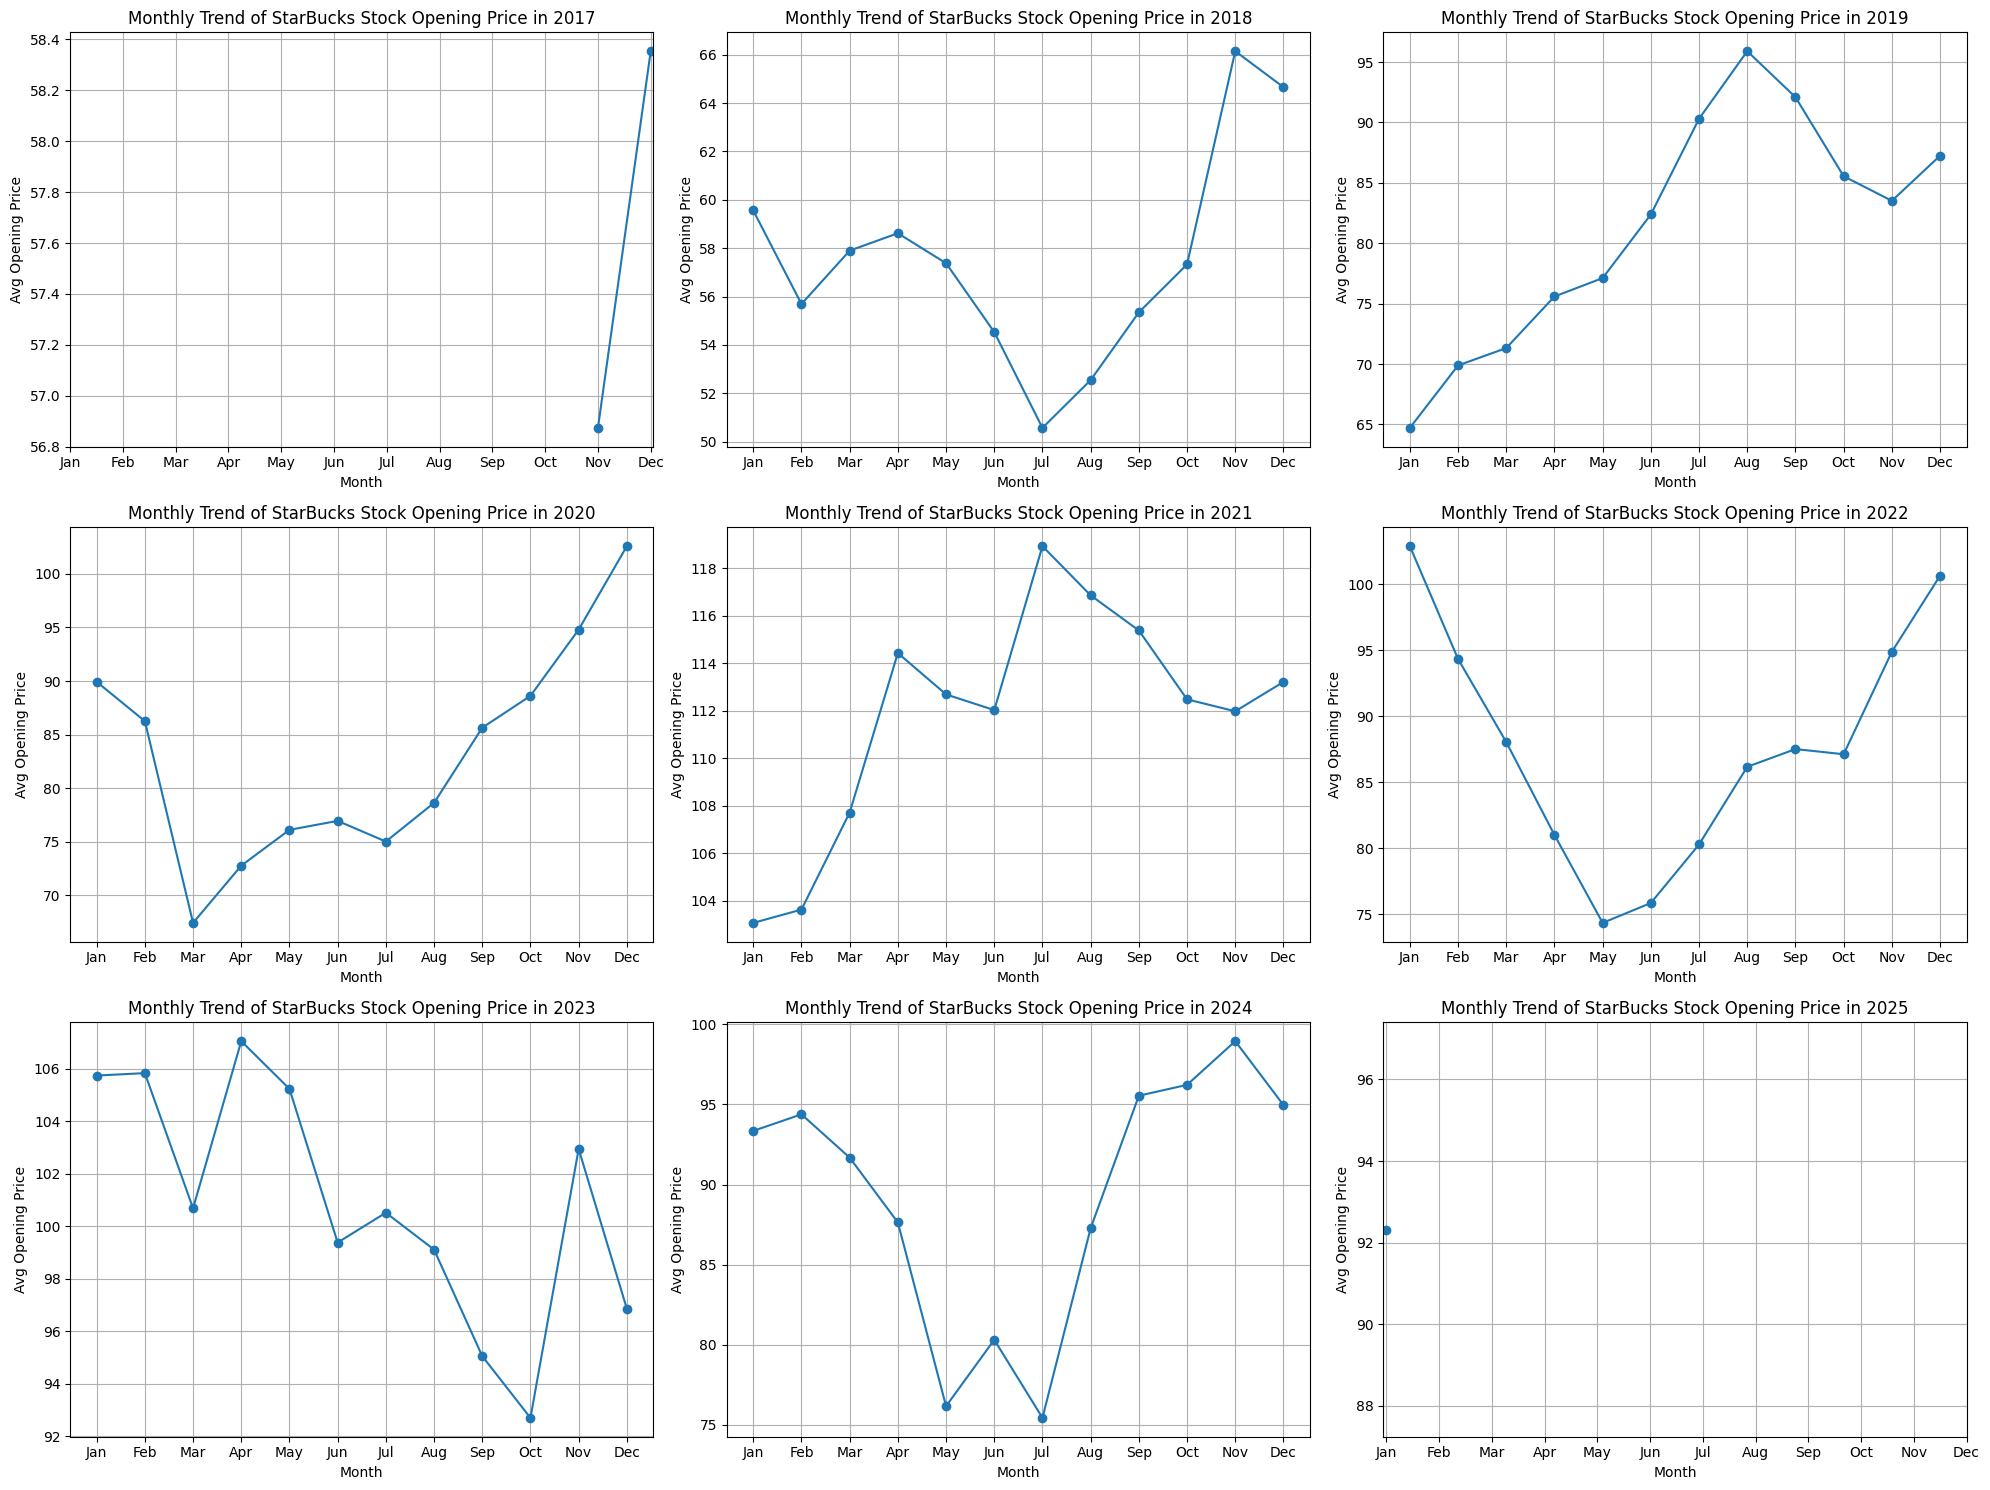

In [ ]:
# Set up the plot grid
years = data["Year"].unique()

# Determine the number of rows and columns (3x3)
n_cols = 3
n_rows = (len(years) // n_cols) + (1 if len(years) % n_cols > 0 else 0)

# Create subplots with a 3x3 grid (adjust size based on number of years)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten the axes array to easily loop through
axes = axes.flatten()

# Plot monthly trends separately for each year
for i, year in enumerate(years):
    yearly_data = data[data["Year"] == year].groupby("Month")["Open"].mean()
    axes[i].plot(yearly_data.index, yearly_data, marker="o", linestyle="-")
    axes[i].set_title(f"Monthly Trend of StarBucks Stock Opening Price in {year}")
    axes[i].set_ylabel("Avg Opening Price")
    axes[i].grid(True)

    # Set x-axis labels for each subplot
    axes[i].set_xlabel("Month")
    axes[i].set_xticks(range(1, 13))  # Set x-ticks for months
    axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Turn off any extra subplots if there are fewer than 9 years
for i in range(len(years), len(axes)):
    axes[i].axis("off")

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.show()

### **c. Average Monthly Trend of StarBucks Open Price Across the Years (2017 to 2025)**

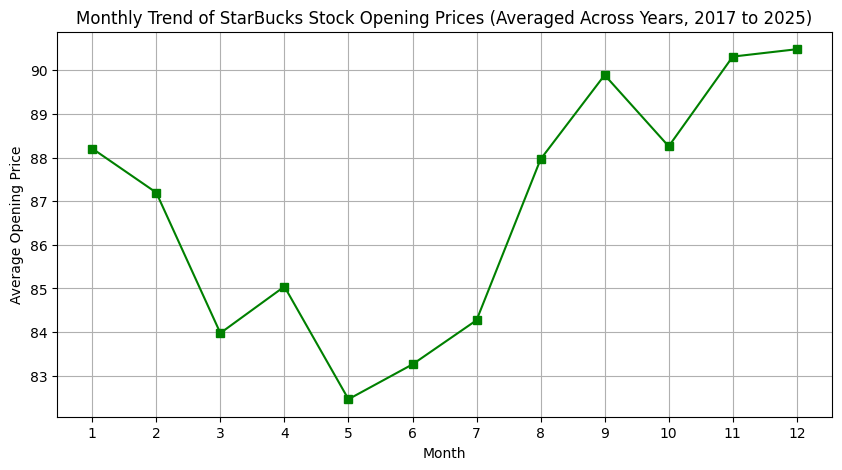

In [ ]:
# Monthly trend visualization
plt.figure(figsize=(10, 5))
data.groupby("Month")["Open"].mean().plot(marker="s", linestyle="-", color="green")
plt.title("Monthly Trend of StarBucks Stock Opening Prices (Averaged Across Years, 2017 to 2025)")
plt.xlabel("Month")
plt.ylabel("Average Opening Price")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

.

.

# **BUILDING DEEP NEURAL NETWORDS FOR STARBUCKS STOCK PRICE PREDICTION**

## **1. Feature Engineering**



### **a. Generating features that can improve Open price prediction**

In [ ]:
# Preprocessing and feature engineering
data_fe = data.drop(columns=['Unnamed: 0', 'Time'])

# Convert date to datetime
data_fe['Date'] = pd.to_datetime(data_fe['Date'])

# Extract time-based features
data_fe['Year'] = data_fe['Date'].dt.year
data_fe['Month'] = data_fe['Date'].dt.month
data_fe['DayOfWeek'] = data_fe['Date'].dt.dayofweek

# Generate lag features
data_fe['Lag_1'] = data_fe['Open'].shift(1)

# Generate moving averages
data_fe['MA_7'] = data_fe['Open'].rolling(window=7).mean()

# Volatility (standard deviation)
data_fe['STD_3'] = data_fe['Open'].rolling(window=3).std()

# Percentage change
data_fe['Pct_Change_1D'] = data_fe['Open'].pct_change(periods=1)
data_fe['Pct_Change_5D'] = data_fe['Open'].pct_change(periods=5)

# Drop rows with NaNs from lag and rolling windows
df = data_fe.dropna().reset_index(drop=True)

# Display the first few rows of the engineered dataset
df


,Date,Open,Year,Month,DayOfWeek,Lag_1,MA_7,STD_3,Pct_Change_1D,Pct_Change_5D
0,2017-11-21,56.96,2017,11,1,56.67,56.841429,0.285015,0.005117,0.008677
1,2017-11-22,57.07,2017,11,2,56.96,56.878571,0.206640,0.001931,0.004400
2,2017-11-24,57.19,2017,11,4,57.07,56.981429,0.115036,0.002103,0.004743
3,2017-11-27,56.83,2017,11,0,57.19,56.982857,0.183303,-0.006295,-0.007163
4,2017-11-28,56.03,2017,11,1,56.83,56.855714,0.593745,-0.014077,-0.011293
...,...,...,...,...,...,...,...,...,...,...
1789,2025-01-03,92.40,2025,1,4,91.55,90.520000,0.835045,0.009285,0.033904
1790,2025-01-06,92.04,2025,1,0,92.40,91.182857,0.426654,-0.003896,0.012541
1791,2025-01-07,92.78,2025,1,1,92.04,91.670000,0.370045,0.008040,0.016322
1792,2025-01-08,92.97,2025,1,2,92.78,91.965714,0.491359,0.002048,0.024689


### **b. Visualising the correlation between features**

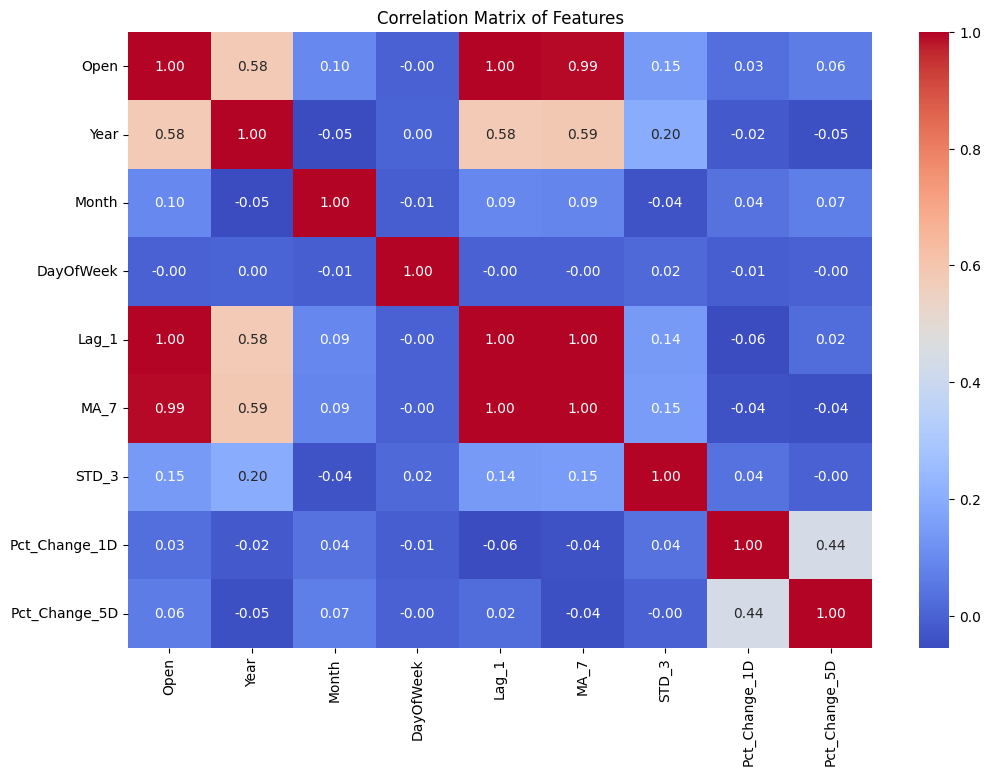

In [ ]:
# Compute correlation matrix for the engineered features (excluding Date and Open)
corr_matrix = df.drop(columns= ['Date']).corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()



*   Features like Lag_1 and MA_7 are highly correlated with Open price and each other. We'll check multicollinearity to avoid reduntancy.
*   Percentage change and standard deviation are not highly correlated with other features.



### **c. Checking for Multicollinearity using Variance Inflation Factor (VIF)**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We will drop the Date column (non-numeric) and predictive target variable 'Open'
X = df.drop(columns=['Date', 'Open'])

# Standardize features for VIF (important for numerical stability)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


         Feature         VIF
3          Lag_1  898.968593
4           MA_7  896.962312
7  Pct_Change_5D    8.602739
6  Pct_Change_1D    3.786547
0           Year    1.584610
5          STD_3    1.046744
1          Month    1.032298
2      DayOfWeek    1.001213




*   Lag_1 and MA_7 have very high VIF values, indicating multicolinearity.
*   Pct_Change_5D also have a VIF value > 5, indicating possibel multicolinearity.

*   We will drop those features excluding Lag_1 and those with VIF values < 5





### **d. Selected Features**

*   selected_features = ['Year', 'Month', 'DayOfWeek', 'Lag_1','STD_3', 'Pct_Change_1D']


.

## 2. **Data Preparation, Spliting, and Scaling**


Shapes of scaled feature sets:
X_train_scaled: (1435, 6)
X_val_scaled:   (179, 6)
X_test_scaled:  (180, 6)

Shapes of scaled target sets:
y_train_scaled: (1435, 1)
y_val_scaled:   (179, 1)
y_test_scaled:  (180, 1)


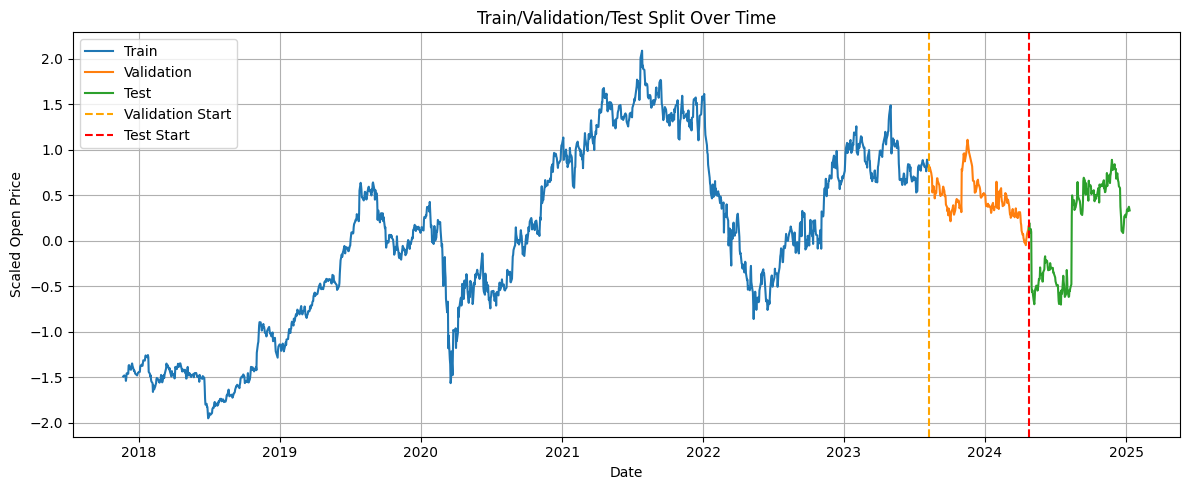

In [ ]:
#------------------------------Data Preparation---------------------------------

# sort dataframe by date
df = df.sort_values('Date').reset_index(drop=True)

# define selected features
selected_features = ['Year', 'Month', 'DayOfWeek', 'Lag_1',
                     'STD_3', 'Pct_Change_1D']

# extract feature matrix and target
X = df[selected_features].values
y = df['Open'].values.reshape(-1, 1)

# save Dates separately for plotting
dates = df['Date'].values

#----------------------Chronological split (80/10/10)---------------------------

n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
dates_train, dates_val, dates_test = dates[:train_end], dates[train_end:val_end], dates[val_end:]

#---------------------Scaling (fit ONLY on training data)-----------------------

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train) # Fit
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train) # Fit
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Print the shapes
print("\nShapes of scaled feature sets:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:  ", X_val_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)

print("\nShapes of scaled target sets:")
print("y_train_scaled:", y_train_scaled.shape)
print("y_val_scaled:  ", y_val_scaled.shape)
print("y_test_scaled: ", y_test_scaled.shape)

#------------------Visualising the split using the Date column------------------

plt.figure(figsize=(12, 5))

# Plot each dataset
plt.plot(dates_train, y_train_scaled, label='Train')
plt.plot(dates_val, y_val_scaled, label='Validation')
plt.plot(dates_test, y_test_scaled, label='Test')

# Add vertical lines at split points
plt.axvline(x=dates_val[0], color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=dates_test[0], color='red', linestyle='--', label='Test Start')

# Formatting
plt.xlabel('Date')
plt.ylabel('Scaled Open Price')
plt.title('Train/Validation/Test Split Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


.

## 3. **BUILDING MODELS**

---
### **MODEL 1: Feed-Forward Neural Network**

*   Existing Deep Neural Network
*   Processes the data independently at each time instance
---


#### 	**I. Build, Train, Predict, and Evaluate Model**

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7146 - mae: 0.6677 - val_loss: 0.0740 - val_mae: 0.2253
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1606 - mae: 0.3109 - val_loss: 0.0251 - val_mae: 0.1185
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1077 - mae: 0.2541 - val_loss: 0.0111 - val_mae: 0.0898
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886 - mae: 0.2253 - val_loss: 0.0157 - val_mae: 0.1007
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0802 - mae: 0.2124 - val_loss: 0.0101 - val_mae: 0.0857
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0714 - mae: 0.2014 - val_loss: 0.0106 - val_mae: 0.0821
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0594 - mae: 0.1872 - val_loss: 0.0085 - val_mae: 0.0760
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0556 - mae: 0.1795 - val_loss: 0.0067 - val_mae: 0.0665
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0498 - mae:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,685 (30.02 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124 (20.02 KB)

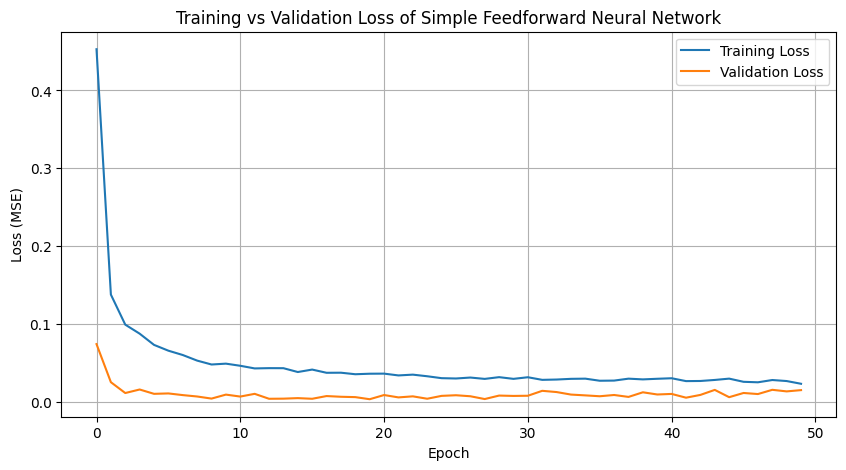

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


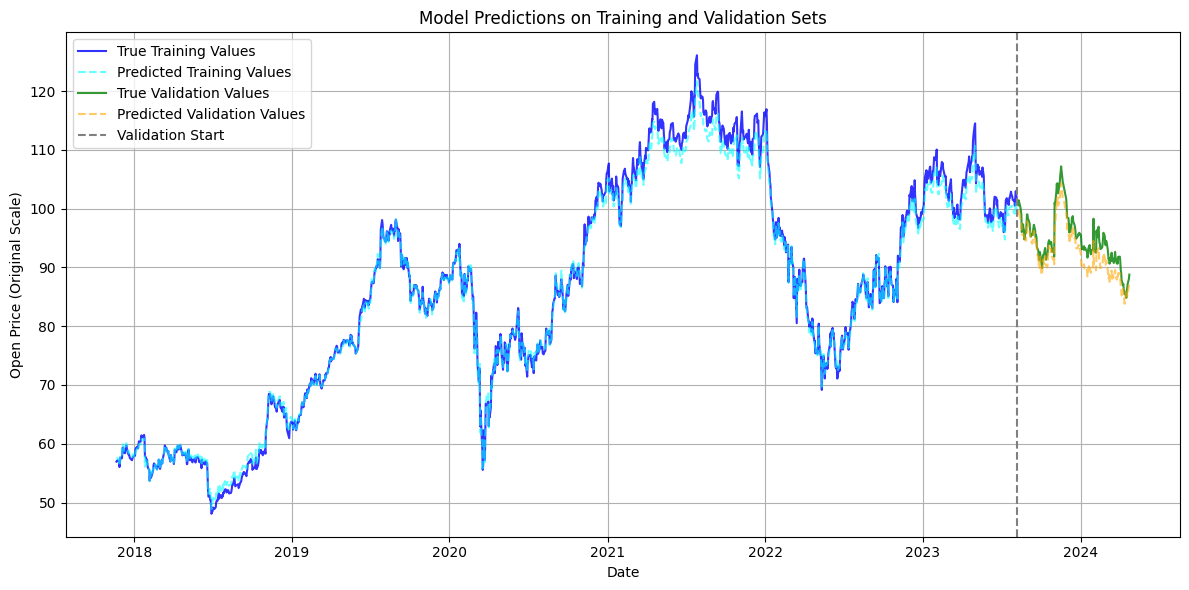

val_MAE: 2.1518
val_MSE: 5.5348
val_RMSE: 2.3526
val_R² Score: 0.7186


In [ ]:

#-----------------------------------BUILD---------------------------------------


# Build a simple feedforward neural network
FFNN_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

FFNN_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


#---------------------------TRAIN and SAVE MODEL--------------------------------


# Training the model
history = FFNN_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=50, batch_size=16, verbose=1)

# Save the model
FFNN_model.save('FFNN_model_saved.keras')

# Model summary
FFNN_model.summary()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss of Simple Feedforward Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#-----------------------PREDICT TRAIN AND VALIDATION SET------------------------

# Make predictions for training and validation sets
train_predictions = FFNN_model.predict(X_train_scaled)
val_predictions = FFNN_model.predict(X_val_scaled)

# Inverse transform the scaled predictions and true values
y_train_original = scaler_y.inverse_transform(y_train_scaled)
train_predictions_original = scaler_y.inverse_transform(train_predictions)

y_val_original = scaler_y.inverse_transform(y_val_scaled)
val_predictions_original = scaler_y.inverse_transform(val_predictions)


#-----------------------------PLOT PREDICTIONS----------------------------------


plt.figure(figsize=(12, 6))

# Training set: True vs Predicted
plt.plot(dates_train, y_train_original, label='True Training Values', alpha=0.8, color='blue')
plt.plot(dates_train, train_predictions_original, label='Predicted Training Values', alpha=0.6, linestyle='--', color='cyan')

# Validation set: True vs Predicted
plt.plot(dates_val, y_val_original, label='True Validation Values', alpha=0.8, color='green')
plt.plot(dates_val, val_predictions_original, label='Predicted Validation Values', alpha=0.6, linestyle='--', color='orange')

# Add vertical lines to mark dataset splits
plt.axvline(x=dates_val[0], color='grey', linestyle='--', label='Validation Start')

# Formatting and labels
plt.xlabel('Date')
plt.ylabel('Open Price (Original Scale)')
plt.title('Model Predictions on Training and Validation Sets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#--------------------EVALUATE PREDICTION ON VALIDATION SET----------------------


# Calculate metrics
mae = mean_absolute_error(y_val_original, val_predictions_original)
mse = mean_squared_error(y_val_original, val_predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_original, val_predictions_original)

# Print the results
print(f"val_MAE: {mae:.4f}")
print(f"val_MSE: {mse:.4f}")
print(f"val_RMSE: {rmse:.4f}")
print(f"val_R² Score: {r2:.4f}")

.

#### **II. Tune/Optimise the Model**

##### **a. Search for best Hyperparameters**

In [ ]:
#---------------------Define model builder function-----------------------------

def build_model(hp):
    model = Sequential()

    # Input layer + First Hidden Layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_1', ['relu', 'tanh']),
        input_shape=(X_train_scaled.shape[1],)
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Second Hidden Layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_2', ['relu', 'tanh'])
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compiling model with tunable learning rate and optimizer
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mse',
        metrics=['mae']
    )

    return model

#---------------------------Initialize tuner------------------------------------

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_results',
    project_name='stock_price_tuning'
)

#-------------------------Hyperparameter search---------------------------------

tuner.search(X_train_scaled, y_train_scaled, epochs=50, validation_data=(X_val_scaled, y_val_scaled))

# Getting best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Reloading Tuner from keras_tuner_results/stock_price_tuning/tuner0.json
Best hyperparameters: {'units_1': 192, 'activation_1': 'tanh', 'dropout_1': 0.30000000000000004, 'units_2': 96, 'activation_2': 'tanh', 'dropout_2': 0.2, 'optimizer': 'sgd'}


##### **b. Build, Train, predict, and evaluate Optimised Model**

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3116 - mae: 0.3966 - val_loss: 0.0118 - val_mae: 0.1002
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855 - mae: 0.2255 - val_loss: 0.0021 - val_mae: 0.0390
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0636 - mae: 0.1902 - val_loss: 0.0027 - val_mae: 0.0414
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0639 - mae: 0.1954 - val_loss: 0.0038 - val_mae: 0.0552
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - mae: 0.1831 - val_loss: 0.0055 - val_mae: 0.0610
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478 - mae: 0.1688 - val_loss: 0.0022 - val_mae: 0.0388
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0425 - mae: 0.1613 - val_loss: 0.0013 - val_mae: 0.0171
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - mae: 0.1551 - val_loss: 8.0431e-04 - val_mae: 0.0171
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - mae: 0.1410 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 192)                 │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 96)                  │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,971 (78.02 KB)

 Trainable params: 19,969 (78.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

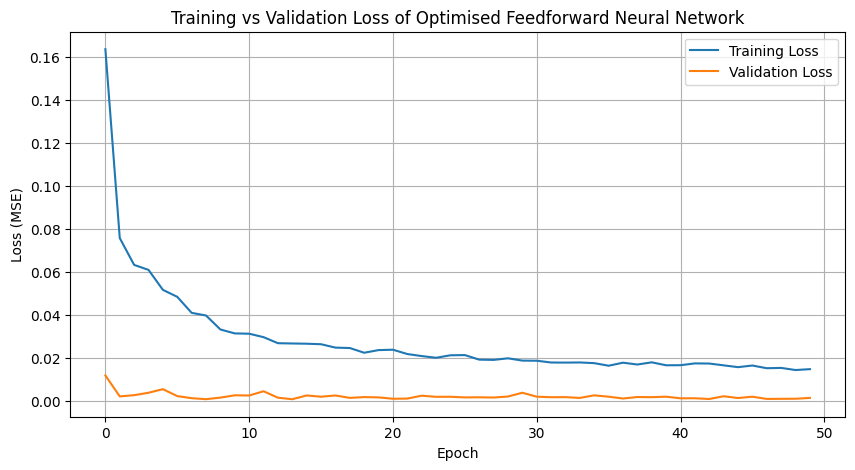

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE: 0.3955
MSE: 0.4399
RMSE: 0.6632
R² Score: 0.9952


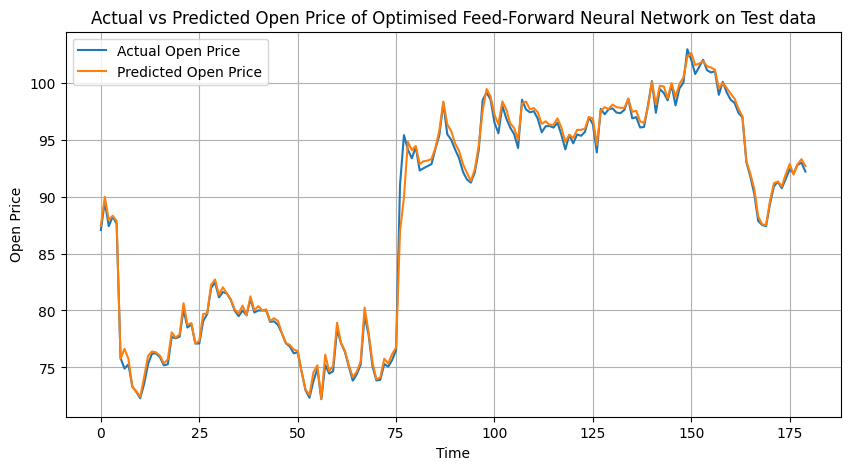

In [ ]:
#-----------------------------BUILD---------------------------------------------

# Building the Optimised FFNN model with best hyperparameters
Optimised_FFNN_model = tuner.hypermodel.build(best_hps)


# -------------------TRAIN and SAVE Optimised Model-----------------------------

# Training the Optimised_FNN_model
history_new = Optimised_FFNN_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=50, batch_size=16, verbose=1)

# Save the model
Optimised_FFNN_model.save('Optimised_FFNN_model_saved.keras')

# Model summary
Optimised_FFNN_model.summary()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss of Optimised Feedforward Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#------------------------------PREDICT------------------------------------------


# Make predictions on test set
y_pred_scaled_ffnn = Optimised_FFNN_model.predict(X_test_scaled)

# Inverse transform predictions and actuals to get real price values
y_pred_ffnn = scaler_y.inverse_transform(y_pred_scaled_ffnn)
y_true = scaler_y.inverse_transform(y_test_scaled)


#------------------------------EVALUATE-----------------------------------------

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred_ffnn)
mse = mean_squared_error(y_true, y_pred_ffnn)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_ffnn)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Open Price')
plt.plot(y_pred_ffnn, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price of Optimised Feed-Forward Neural Network on Test data')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.show()

##### **c. Future Prediction**

*   Our aim is to predict the next day open stock price and this Feed-forward neural network is tailored for that. It does not have memory or sequential awareness, making it best suitable for predicting the next day open stock price.




In [ ]:
#---------------------PREDICT THE NEXT DAY OPEN PRICE---------------------------

from datetime import timedelta

def predict_next_day_open(df, model, scaler_X, scaler_y, selected_features):
    # Get last row of features
    latest_features = df[selected_features].iloc[-1].values.reshape(1, -1)

    # Scale the features
    latest_features_scaled = scaler_X.transform(latest_features)

    # Predict
    predicted_scaled = Optimised_FFNN_model.predict(latest_features_scaled)
    predicted_open = scaler_y.inverse_transform(predicted_scaled)[0][0]

    # Get next date
    last_date = pd.to_datetime(df['Date'].iloc[-1])
    next_date = last_date + timedelta(days=1)

    return next_date.date(), float(predicted_open)

next_date, next_day_price = predict_next_day_open(df, Optimised_FFNN_model, scaler_X, scaler_y, selected_features)
print(f"📅 Predicted Open Price for {next_date}: ${next_day_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📅 Predicted Open Price for 2025-01-11: $92.68


.

.

---
### **MODEL 2: Long Short-Term Memory**

*   Existing Deep Neural Network for Stock Price Prediction
*   The model considers the task as a timeseries
---

#### 	**I. Build, Train, Predict, and Evaluate Model**


Using sequence length: 50

Shapes of sequence data:
X_train_seq: (1385, 50, 6)
y_train_seq: (1385, 1)
X_val_seq:   (129, 50, 6)
y_val_seq:   (129, 1)
X_test_seq:  (130, 50, 6)
y_test_seq:  (130, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 96)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,097 (312.88 KB)

 Trainable params: 80,097 (312.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.9719 - val_loss: 0.1559
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0732 - val_loss: 0.0449
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0825 - val_loss: 0.0346
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0497 - val_loss: 0.0396
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0296 - val_loss: 0.0249
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0180 - val_loss: 0.0214
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0333 - val_loss: 0.0200
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0167 - val_loss: 0.0186
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0133 - val_loss: 0.0155
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0150 - val_loss: 0.0170
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0

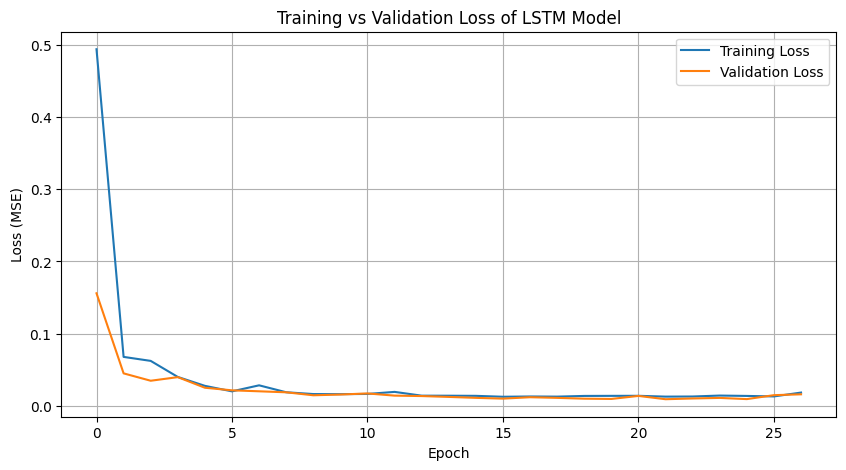

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


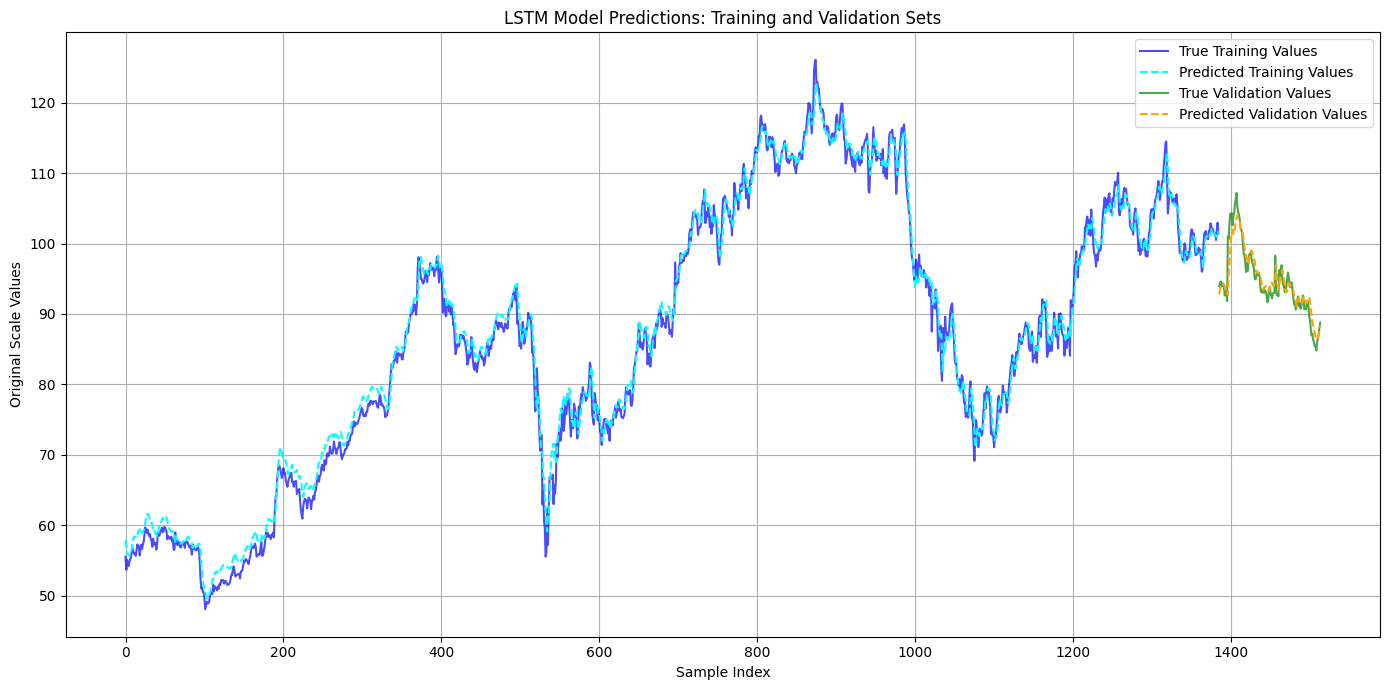

Validation Metrics:
Val_MAE: 1.3252
Val_MSE: 3.3593
Val_RMSE: 1.8328
Val_R² Score: 0.8558


In [ ]:

#---------------------------CREATE SEQUENCE-------------------------------------

# Create sequence for lstm model
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        # For LSTM, we need a 3D input: [samples, time steps, features]
        # X shape will be [batch, seq_length, 1]
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define sequence length
seq_len = 50
print(f"\nUsing sequence length: {seq_len}")

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

# Print the sequence shapes
print("\nShapes of sequence data:")
print("X_train_seq:", X_train_seq.shape)  # [samples, time steps, features]
print("y_train_seq:", y_train_seq.shape)  # [samples, 1]
print("X_val_seq:  ", X_val_seq.shape)
print("y_val_seq:  ", y_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape)
print("y_test_seq: ", y_test_seq.shape)


#------------------------------BUILD MODEL--------------------------------------


# Build model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(96),
    Dropout(0.1),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.00024), loss='mse')
model.summary()

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    CSVLogger('training_log.csv', append=True)
]


#-----------------------------TRAIN MODEL---------------------------------------


# Train model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

# Save the model
model.save("stock_lstm_model.keras")

# Plot Validation and Training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss of LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#--------------------PREDICT TRAIN AND VALIDATION SET---------------------------


# Make predictions for the training and validation sets
train_pred = model.predict(X_train_seq)
val_pred = model.predict(X_val_seq)

# Inverse transform the scaled predictions and true values
y_train_original = scaler_y.inverse_transform(y_train_seq)
train_pred_original = scaler_y.inverse_transform(train_pred)

y_val_original = scaler_y.inverse_transform(y_val_seq)
val_pred_original = scaler_y.inverse_transform(val_pred)

# Plot the true values and predictions for both training and validation sets
plt.figure(figsize=(14, 7))

# Plot training set predictions
plt.plot(y_train_original, label='True Training Values', color='blue', alpha=0.7)
plt.plot(train_pred_original, label='Predicted Training Values', color='cyan', linestyle='--')

# Plot validation set predictions
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_original,
         label='True Validation Values', color='green', alpha=0.7)
plt.plot(range(len(y_train_original), len(y_train_original) + len(val_pred_original)), val_pred_original,
         label='Predicted Validation Values', color='orange', linestyle='--')

# Formatting and titles
plt.title('LSTM Model Predictions: Training and Validation Sets')
plt.xlabel('Sample Index')
plt.ylabel('Original Scale Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#-----------------------------EVALUATE------------------------------------------


# Calculate evaluation metrics for the validation set
mae = mean_absolute_error(y_val_original, val_pred_original)
mse = mean_squared_error(y_val_original, val_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_original, val_pred_original)

# Print evaluation results
print(f"Validation Metrics:")
print(f"Val_MAE: {mae:.4f}")
print(f"Val_MSE: {mse:.4f}")
print(f"Val_RMSE: {rmse:.4f}")
print(f"Val_R² Score: {r2:.4f}")




.

#### **II. Tune/Optimise the Model**

##### **a. Search for Best Hyperparameters**

In [ ]:

#----------------Define model builder function for Keras Tuner------------------


def build_model(hp):

    # Define input_shape directly without hp.Fixed
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    model = Sequential()

    # Tune the number of LSTM units
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=input_shape
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32)
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Tune learning rate for Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )

    return model


#-----------------Initialize Tuner with Random Search---------------------------


tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning'
)



#-----------------------Hyperparameter search-----------------------------------

tuner.search(
    X_train_seq, y_train_seq,
    epochs=50,   # Number of epochs per trial
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq)
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

print("Best Hyperparameters:", best_hp.values)



Reloading Tuner from my_dir/lstm_tuning/tuner0.json
Best Hyperparameters: {'units': 128, 'dropout_1': 0.30000000000000004, 'units_2': 64, 'dropout_2': 0.4, 'learning_rate': 0.002355545875404161}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##### **b. Build, Train, Predict, and Evaluate Optimised model**

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.4832 - mae: 0.5325 - val_loss: 0.0720 - val_mae: 0.2364
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.2020 - mae: 0.3501 - val_loss: 0.0418 - val_mae: 0.1616
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.1580 - mae: 0.3221 - val_loss: 0.0229 - val_mae: 0.1271
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.2783 - mae: 0.4253 - val_loss: 0.0124 - val_mae: 0.0826
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.1668 - mae: 0.3328 - val_loss: 0.0272 - val_mae: 0.1475
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1209 - mae: 0.2811 - val_loss: 0.0242 - val_mae: 0.1374
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0557 - mae: 0.1839 - val_loss: 0.0243 - val_mae: 0.1376
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0333 - mae: 0.1398 - val_loss: 0.0160 - val_mae: 0.1054
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 

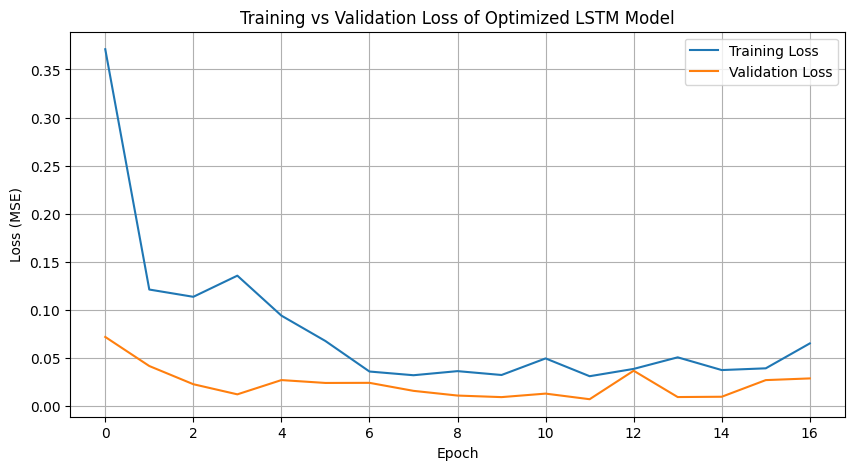

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


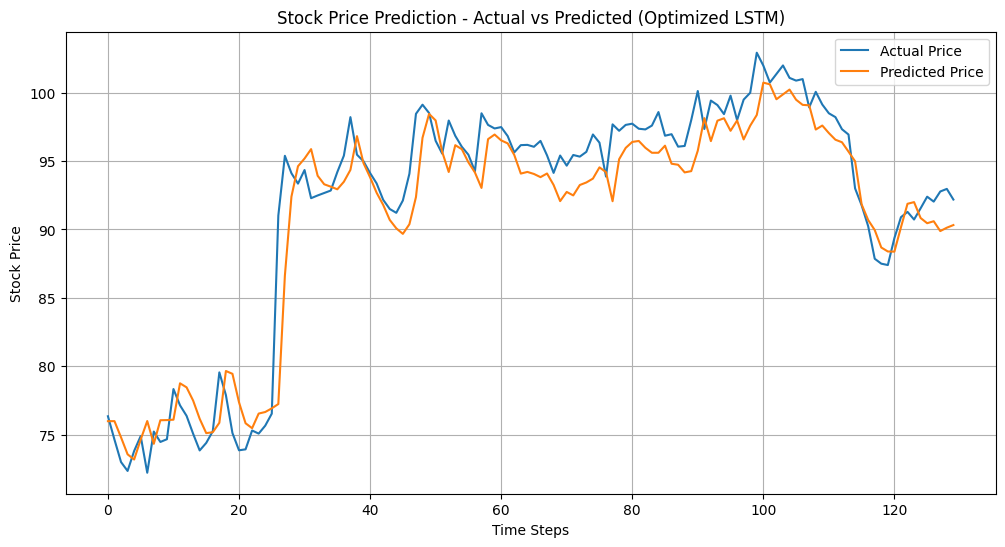

Test MAE: 1.8252
Test MSE: 6.3365
RMSE: 2.5172
R² Score: 0.9183


In [ ]:
#--------------------------Build and Train best_model---------------------------

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    CSVLogger('training_log.csv', append=True)
]

history_best = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

# Plot Validation and Training loss
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss of Optimized LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#----------------------------Predict on the test set----------------------------
y_pred_scaled = best_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Stock Price Prediction - Actual vs Predicted (Optimized LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


#-------------------------------Evaluate the model------------------------------

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

.

#### **III. Future prediction**

In [ ]:
# Extract the last sequence from the test set
last_sequence = X_test_scaled[-seq_len:].reshape(1, seq_len, X_test_scaled.shape[1])

# Predict the next day's price
next_day_prediction_scaled = best_model.predict(last_sequence)

# Inverse transform the predicted value
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)
print(f"Predicted Next Day Open Price: {next_day_prediction[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Next Day Open Price: 89.74


.

.

---
### **MODEL 3: Attention-Gated Recurrent Network**

*   A Custom Hybrid Model
*   The model considers the task as a timeseries
---


#### **I. Build, Train, Predict, and Evaluate the Model**

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 30, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 30, 64)         │         13,824 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 30, 1)          │             65 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 1, 30)          │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_weights         │ (None, 1, 30)          │              0 │ permute[0][0]          │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_1 (Permute)       │ (None, 30, 1)          │              0 │ attention_weights[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 30, 64)         │              0 │ gru[0][0],             │
│                           │                        │                │ permute_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 32)             │          9,408 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │             33 │ gru_1[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,330 (91.13 KB)

 Trainable params: 23,330 (91.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.3145 - mae: 1.0012 - val_loss: 0.1746 - val_mae: 0.3614
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8740 - mae: 0.7996 - val_loss: 0.0369 - val_mae: 0.1587
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2227 - mae: 0.4101 - val_loss: 0.1421 - val_mae: 0.3230
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0771 - mae: 0.2345 - val_loss: 0.0562 - val_mae: 0.1983
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0379 - mae: 0.1630 - val_loss: 0.0298 - val_mae: 0.1345
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0172 - mae: 0.1002 - val_loss: 0.0207 - val_mae: 0.1097
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0146 - mae: 0.0927 - val_loss: 0.0170 - val_mae: 0.0998
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0139 - mae: 0.0931 - val_loss: 0.0151 - val_mae: 0.0949
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.009

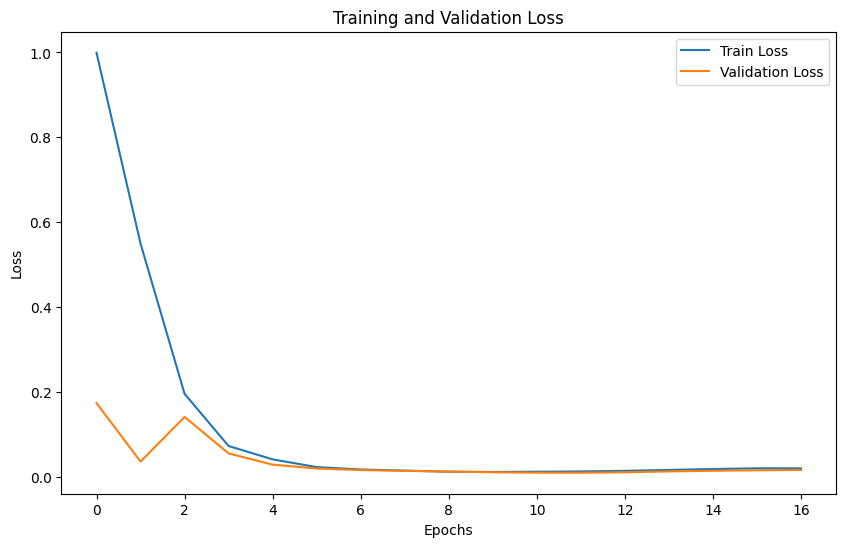

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


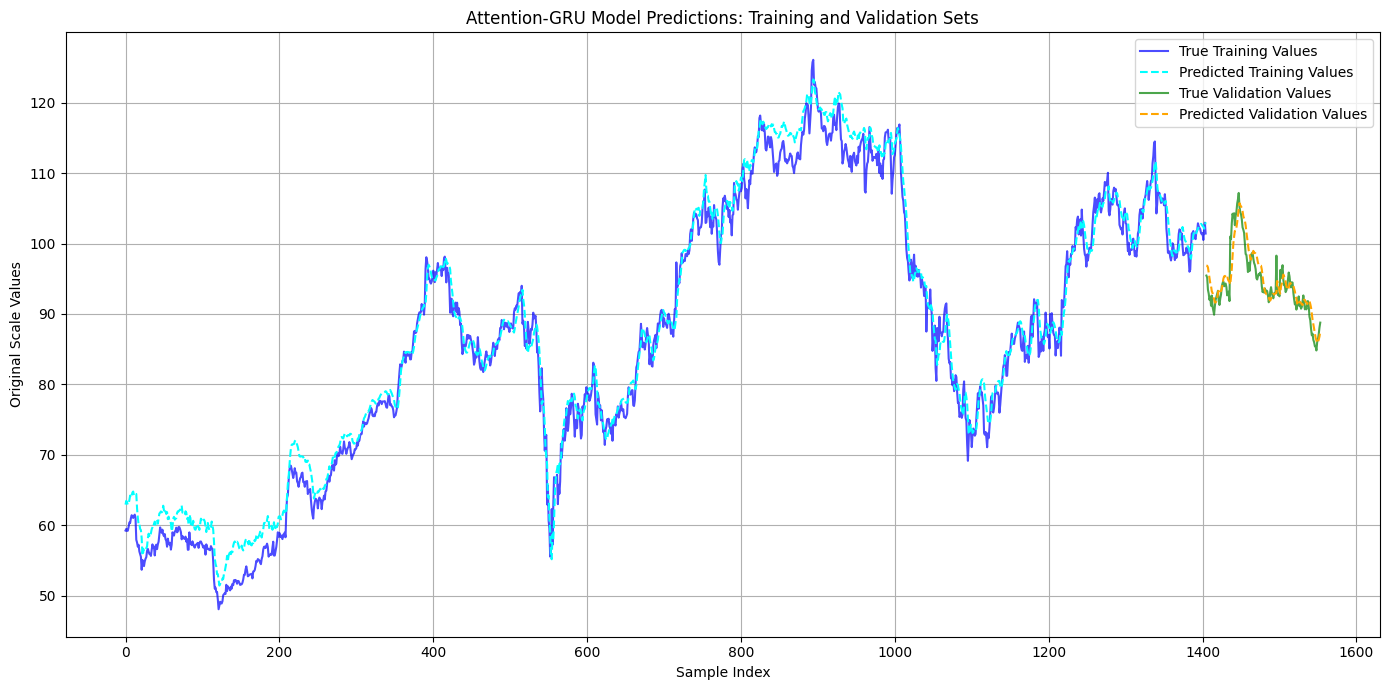

Validation Metrics:
MAE: 1.5472
MSE: 3.9951
RMSE: 1.9988
R² Score: 0.8100


In [ ]:

#---------------------------------BUILD-----------------------------------------


def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define the length of the look-back period
look_back = 30

# Create sequences for training, validation, and test sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, look_back)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, look_back)

# Reshape data for GRU model (samples, time_steps, features)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], X_val_seq.shape[1], X_val_seq.shape[2]))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

# Define the Attention Layer
def attention_layer(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = Permute((2, 1))(attention)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name="attention_weights")(attention)
    attention = Permute((2, 1))(attention)
    output = Multiply()([inputs, attention])
    return output

# Build the Attention-GRU Model
inputs = Input(shape=(look_back, X_train_seq.shape[2]))
gru_out = GRU(64, return_sequences=True)(inputs)
attention_out = attention_layer(gru_out)
gru_out2 = GRU(32)(attention_out)
output = Dense(1)(gru_out2)

# Define the model
model = Model(inputs=inputs, outputs=output)

# Compile the model with multiple metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])
model.summary()


#-----------------------------------TRAIN---------------------------------------


# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_attention_gru_model.keras', monitor='val_loss', save_best_only=True),
    CSVLogger('training_log.csv', append=True)
]

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)


# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#----------------------PREDICT ON TRAIN AND TEST SET----------------------------


# Generate predictions for the training and validation sets
train_predictions = model.predict(X_train_seq)
val_predictions = model.predict(X_val_seq)

# Inverse transform predictions and true values (if scaled)
y_train_original = scaler_y.inverse_transform(y_train_seq)
train_predictions_original = scaler_y.inverse_transform(train_predictions)

y_val_original = scaler_y.inverse_transform(y_val_seq)
val_predictions_original = scaler_y.inverse_transform(val_predictions)

# Plot the true values and predictions for both training and validation sets
plt.figure(figsize=(14, 7))

# Plot training set predictions
plt.plot(y_train_original, label='True Training Values', color='blue', alpha=0.7)
plt.plot(train_predictions_original, label='Predicted Training Values', color='cyan', linestyle='--')

# Plot validation set predictions
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_original,
         label='True Validation Values', color='green', alpha=0.7)
plt.plot(range(len(y_train_original), len(y_train_original) + len(val_predictions_original)), val_predictions_original,
         label='Predicted Validation Values', color='orange', linestyle='--')

# Formatting and titles
plt.title('Attention-GRU Model Predictions: Training and Validation Sets')
plt.xlabel('Sample Index')
plt.ylabel('Original Scale Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#------------------------EVALUATION ON VALIDATION-------------------------------


# Calculate evaluation metrics for the validation set
mae = mean_absolute_error(y_val_original, val_predictions_original)
mse = mean_squared_error(y_val_original, val_predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_original, val_predictions_original)

# Print evaluation results
print(f"Validation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

.

#### **II. Tune/Optimise the Model**

##### **a. Search for Best Hyperparameters, Tune, Build, and Train Optimised Model**

Reloading Tuner from kerastuner_dir/attention_gru_tuning/tuner0.json
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.2512 - mae: 0.3685 - val_loss: 0.0210 - val_mae: 0.1283
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1973 - mae: 0.3828 - val_loss: 0.0285 - val_mae: 0.1388
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.2832 - mae: 0.4553 - val_loss: 0.0486 - val_mae: 0.1776
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2229 - mae: 0.4073 - val_loss: 0.1009 - val_mae: 0.2672
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2060 - mae: 0.3879 - val_loss: 0.0694 - val_mae: 0.2253
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1100 - mae: 0.2759 - val_loss: 0.0354 - val_mae: 0.1566
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0287 - mae: 0.1396 - val_loss: 0.0135 - val_mae: 0.0986
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0285 - mae: 0.1305 - val_loss: 0.0266 - val_mae: 0.1276
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0168 - mae: 0.

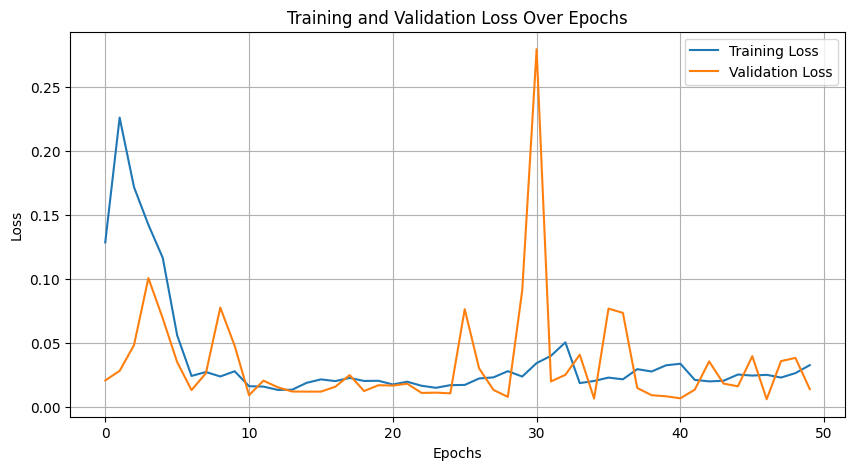

In [ ]:

#-------------------Define function for tuner-----------------------------------


def attention_layer(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = Permute((2, 1))(attention)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name="attention_weights")(attention)
    attention = Permute((2, 1))(attention)
    output = Multiply()([inputs, attention])
    return output

def build_model(hp):
    inputs = Input(shape=(look_back, X_train_seq.shape[2]))

    # First GRU layer
    gru_units_1 = hp.Int('gru_units_1', min_value=32, max_value=128, step=32)
    gru_out = GRU(gru_units_1, return_sequences=True)(inputs)

    # Attention
    attention_out = attention_layer(gru_out)

    # Second GRU layer
    gru_units_2 = hp.Int('gru_units_2', min_value=16, max_value=64, step=16)
    gru_out2 = GRU(gru_units_2)(attention_out)

    # Dropout
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(gru_out2)

    # Output layer
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)

    # Optimiser
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model


#---------------------------Tuner Search----------------------------------------


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='kerastuner_dir',
    project_name='attention_gru_tuning'
)


tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]


#----------------------------Train best model-----------------------------------

# Optional: Retrain with more epochs
history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    shuffle=False
)

best_model.save('best_attention_gru_model.keras')
best_model.summary()

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##### **b. Predict Test Set**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
MAE (Mean Absolute Error): 2.4738
RMSE (Root Mean Squared Error): 3.2545
R² Score: 0.8750


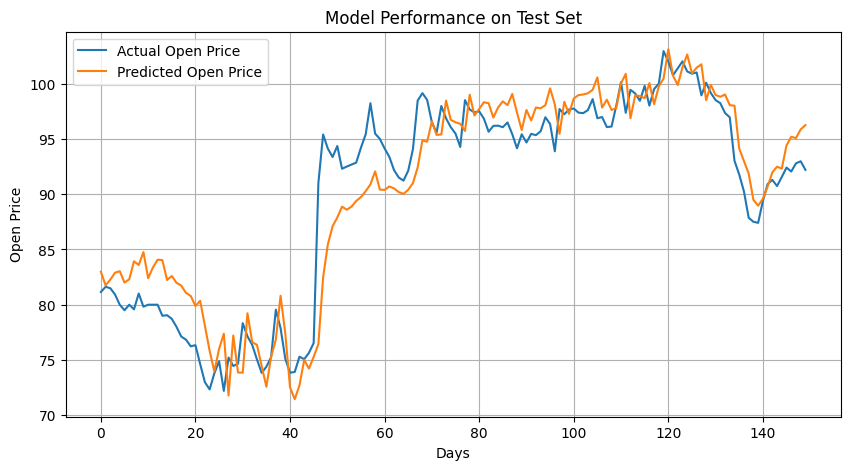

In [ ]:
# Predict on test set
y_pred_scaled = best_model.predict(X_test_seq)

# Inverse transform to get actual price values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Open Price')
plt.plot(y_pred, label='Predicted Open Price')
plt.title('Model Performance on Test Set')
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.show()

.

#### **III. Future Predictions**

In [ ]:
def predict_next_10_days(model, last_sequence, scaler_X, scaler_y, look_back=30):
    predictions = []
    current_sequence = last_sequence.copy()  # Start with the last available sequence

    for _ in range(10):  # Predict 10 days ahead
        # Make a prediction for the next day
        next_day_prediction_scaled = model.predict(current_sequence)

        # Rescale the prediction to the original scale
        next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)[0, 0]

        # Add the prediction to the list
        predictions.append(next_day_prediction)
        new_data_point = np.array([0, 0, 0, next_day_prediction, 0, 0])  # Assume other features are 0 for now
        new_data_point_scaled = scaler_X.transform(new_data_point.reshape(1, -1))  # scale feature

        current_sequence = np.concatenate((current_sequence[:, 1:, :], new_data_point_scaled.reshape(1, 1, -1)), axis=1)

    return predictions


# Get the last sequence from the test data for prediction
last_sequence = X_test_seq[-1].reshape(1, look_back, X_test_seq.shape[2])

# Predict the next 10 days
next_10_days_predictions = predict_next_10_days(best_model, last_sequence, scaler_X, scaler_y, look_back)

# Print the predictions
print("Predictions for the next 10 days:")
for i, prediction in enumerate(next_10_days_predictions):
    print(f"Day {i + 1}: {prediction:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predictions for the next 10 days:
Day 1: 96.24
Day 2: 74.86
Day 3: 68.33
Day 4: 66.69
Day 5: 66.64
Day 6: 67.49
Day 7: 68.66
Day 8: 69.95
Day 9: 71.21
Day 10: 72.28


.

.

### **MODEL 4: Hybrid CNN-BiLSTM-Attention DNN**

*   This is a Custom Hybrid Model
*   It is a  deep network that approaches the task as a time series regression problem.

#### 	**I. Build, Train, Predict, and Evaluate Model**


Epoch 1: Learning rate set to 0.000500
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.8948 - mae: 1.0691 - val_loss: 0.1226 - val_mae: 0.1689

Epoch 2: Learning rate set to 0.001250
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5085 - mae: 0.5017 - val_loss: 0.1510 - val_mae: 0.2401

Epoch 3: Learning rate set to 0.002000
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2282 - mae: 0.3078 - val_loss: 0.1080 - val_mae: 0.1798

Epoch 4: Learning rate set to 0.001800
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1683 - mae: 0.2472 - val_loss: 0.0913 - val_mae: 0.1598

Epoch 5: Learning rate set to 0.001620
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1533 - mae: 0.2399 - val_loss: 0.0786 - val_mae: 0.1411

Epoch 6: Learning rate set to 0.001458
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1353 - mae: 0.2216 - val_loss: 0.0788 - val_mae: 0.1512

Epoch 7: Learning rate set to 0.001312
Epoch 7/50
44/44 ━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 100)   │     22,800 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 100)   │        400 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 30, 100)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 30, 1)     │        101 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 30, 1)     │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 32)    │        224 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 30, 100)   │          0 │ spatial_dropout1… │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 132)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      4,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,044 (324.39 KB)

 Trainable params: 27,614 (107.87 KB)

 Non-trainable params: 200 (800.00 B)

 Optimizer params: 55,230 (215.75 KB)

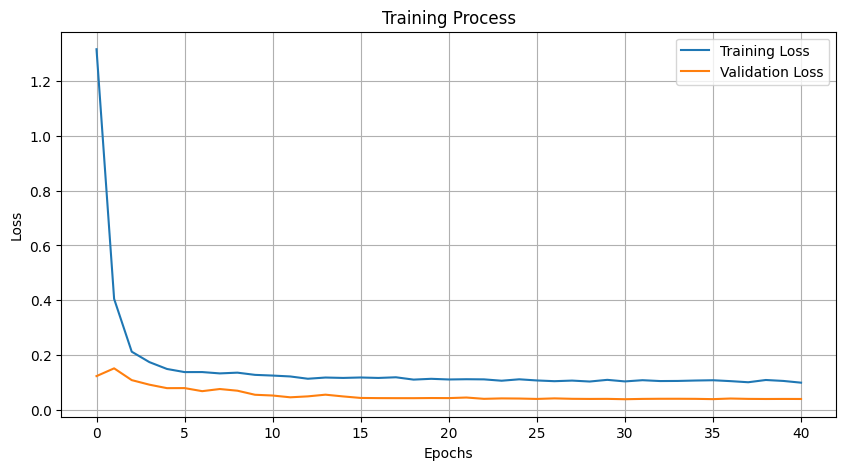

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


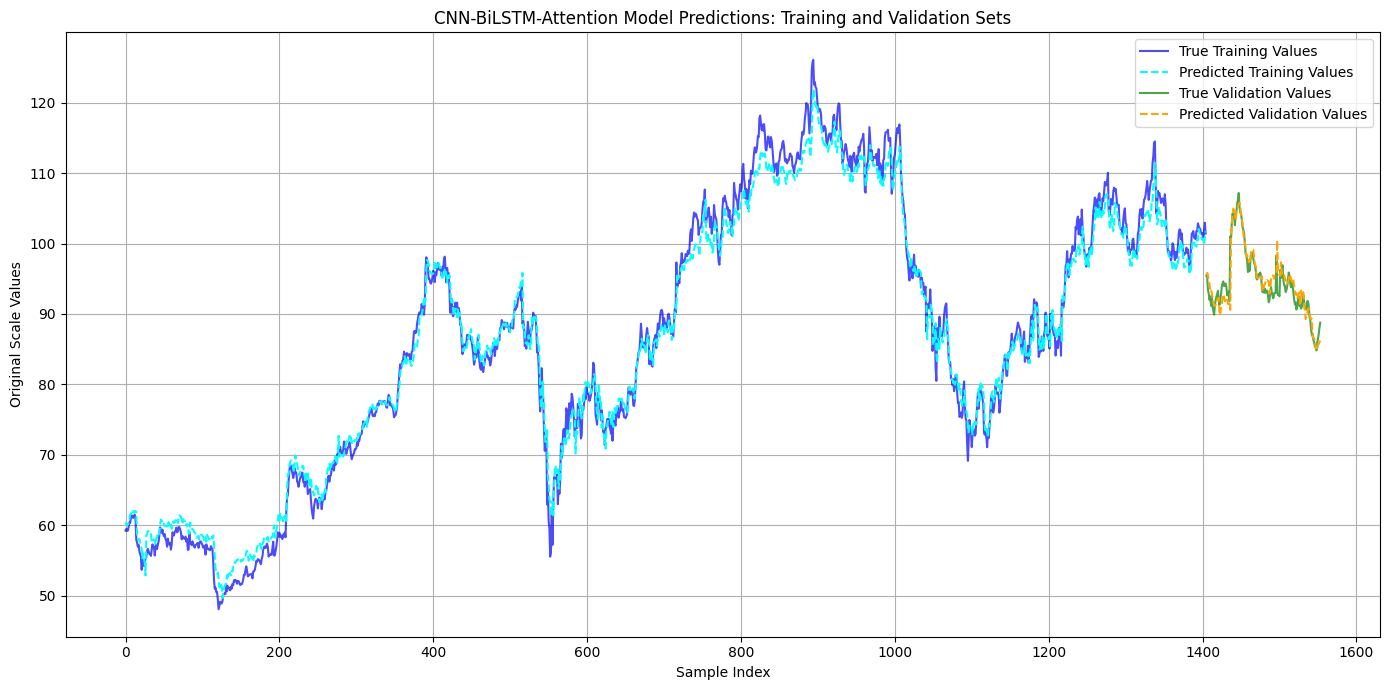

Validation Metrics:
MAE: 1.2281
MSE: 3.0159
RMSE: 1.7366
R² Score: 0.8565


In [ ]:

#-------------------------------------BUILD-------------------------------------


# Create sequences
def create_sequences(X, y, timesteps=30):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps=30)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, timesteps=30)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps=30)

# Custom learning rate scheduler with warm-up and decay
class WarmUpExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.0005, max_lr=0.003, warmup_epochs=2, decay_factor=0.9):
        super().__init__()
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.decay_factor = decay_factor

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Linear warm-up phase
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (epoch / self.warmup_epochs)
        else:
            # Exponential decay phase
            lr = self.max_lr * (self.decay_factor ** (epoch - self.warmup_epochs))

        self.model.optimizer.learning_rate.assign(lr)
        print(f"\nEpoch {epoch+1}: Learning rate set to {lr:.6f}")

# Input layer
input_layer = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# CNN branch with regularization
cnn_layer = Conv1D(filters=32, kernel_size=1, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
cnn_layer = GlobalMaxPooling1D()(cnn_layer)

# BiLSTM branch
lstm_layer = Bidirectional(LSTM(50, return_sequences=True,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)))(input_layer)
lstm_layer = BatchNormalization()(lstm_layer)
lstm_layer = SpatialDropout1D(0.3)(lstm_layer)

# Attention
attention_scores = Dense(1, activation='tanh')(lstm_layer)
attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention_scores)
attention_output = Multiply()([lstm_layer, attention_weights])
attention_output = GlobalAveragePooling1D()(attention_output)

# Merge and dense with regularization
concat_layer = Concatenate()([cnn_layer, attention_output])
dense_layer = Dense(32, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(concat_layer)
dense_layer = Dropout(0.4)(dense_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

# Compile
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Starting LR
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


#---------------------------------TRAIN-----------------------------------------


# Create the scheduler
lr_scheduler = WarmUpExponentialDecay(
    initial_lr=0.0005,
    max_lr=0.002,
    warmup_epochs=2,
    decay_factor=0.9
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train with callbacks
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

model.save('cnn_bilstm_att.keras')
model.summary()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Process')
plt.legend()
plt.grid(True)
plt.show()


#------------------PREDICT TRAIN AND VALIDATION SET-----------------------------


# Make predictions for the training and validation sets
train_pred = model.predict(X_train_seq)
val_pred = model.predict(X_val_seq)

# Inverse transform predictions and true values
y_train_original = scaler_y.inverse_transform(y_train_seq)
train_pred_original = scaler_y.inverse_transform(train_pred)

y_val_original = scaler_y.inverse_transform(y_val_seq)
val_pred_original = scaler_y.inverse_transform(val_pred)

# Plot the true values and predictions for both training and validation sets
plt.figure(figsize=(14, 7))

# Plot training set predictions
plt.plot(y_train_original, label='True Training Values', color='blue', alpha=0.7)
plt.plot(train_pred_original, label='Predicted Training Values', color='cyan', linestyle='--')

# Plot validation set predictions
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_original,
         label='True Validation Values', color='green', alpha=0.7)
plt.plot(range(len(y_train_original), len(y_train_original) + len(val_pred_original)), val_pred_original,
         label='Predicted Validation Values', color='orange', linestyle='--')

# Formatting and titles
plt.title('CNN-BiLSTM-Attention Model Predictions: Training and Validation Sets')
plt.xlabel('Sample Index')
plt.ylabel('Original Scale Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#--------------------EVALUATE ON VALIDATION SET---------------------------------

# Calculate evaluation metrics for the validation set
mae = mean_absolute_error(y_val_original, val_pred_original)
mse = mean_squared_error(y_val_original, val_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_original, val_pred_original)

# Print evaluation results
print(f"Validation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


.

#### **II. Tune/Optimise the Model**

##### **a. Find the Best Hyperparameters, Build, Train, Predict, and Evaluate Tuned Model**

Trial 20 Complete [00h 00m 30s]
val_loss: 0.04969649761915207

Best val_loss So Far: 0.029909616336226463
Total elapsed time: 00h 08m 37s

Epoch 1: Learning rate set to 0.000306
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.4589 - mae: 1.0034 - val_loss: 0.4720 - val_mae: 0.5942

Epoch 2: Learning rate set to 0.000766
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4807 - mae: 0.5380 - val_loss: 0.1044 - val_mae: 0.2263

Epoch 3: Learning rate set to 0.001225
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1929 - mae: 0.3126 - val_loss: 0.0769 - val_mae: 0.1858

Epoch 4: Learning rate set to 0.001102
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1485 - mae: 0.2637 - val_loss: 0.0543 - val_mae: 0.1377

Epoch 5: Learning rate set to 0.000992
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1222 - mae: 0.2373 - val_loss: 0.0580 - val_mae: 0.1490

Epoch 6: Learning rate set to 0.000893
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 140)   │     43,120 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 140)   │        560 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 30, 140)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 1)     │        141 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 30, 1)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 64)    │        448 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 30, 140)   │          0 │ spatial_dropout1… │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 140)       │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 204)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      3,280 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         17 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142,140 (555.24 KB)

 Trainable params: 47,286 (184.71 KB)

 Non-trainable params: 280 (1.09 KB)

 Optimizer params: 94,574 (369.43 KB)

Best Hyperparameters:
cnn_filters: 64
cnn_l2: 0.0001576062643128843
lstm_units: 70
lstm_l2: 0.00014652245947998418
spatial_dropout: 0.4
dense_units: 16
dense_l2: 0.0008498779995648562
dropout_rate: 0.30000000000000004
learning_rate: 0.0003062190916901374


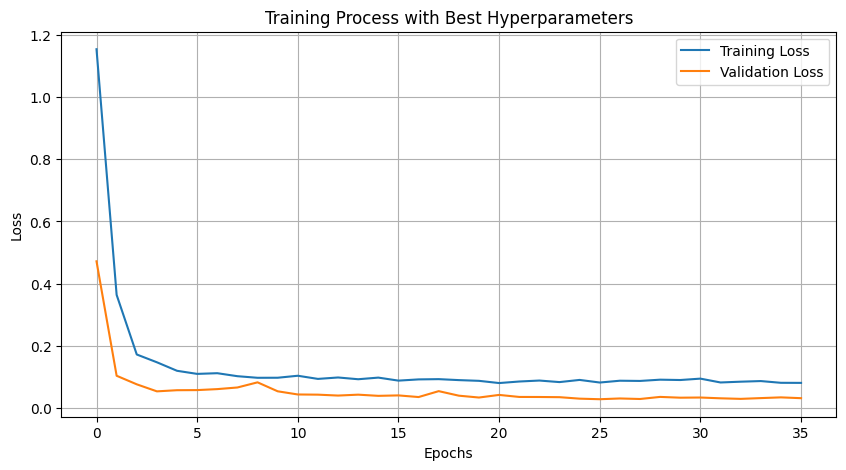

In [ ]:

#-----------Define model-building function for Hyperparameter Tuning------------

def build_model(hp):
    # Input layer remains the same
    input_layer = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    # CNN branch with tunable parameters
    cnn_filters = hp.Int('cnn_filters', min_value=16, max_value=64, step=16)
    cnn_l2 = hp.Float('cnn_l2', min_value=0.0001, max_value=0.01, sampling='log')
    cnn_layer = Conv1D(filters=cnn_filters, kernel_size=1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(cnn_l2))(input_layer)
    cnn_layer = GlobalMaxPooling1D()(cnn_layer)

    # BiLSTM branch with tunable parameters
    lstm_units = hp.Int('lstm_units', min_value=30, max_value=70, step=10)
    lstm_l2 = hp.Float('lstm_l2', min_value=0.0001, max_value=0.01, sampling='log')
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True,
                                  kernel_regularizer=tf.keras.regularizers.l2(lstm_l2)))(input_layer)
    lstm_layer = BatchNormalization()(lstm_layer)

    # Spatial dropout with tunable rate
    spatial_dropout_rate = hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)
    lstm_layer = SpatialDropout1D(spatial_dropout_rate)(lstm_layer)

    # Attention mechanism (remains largely the same)
    attention_scores = Dense(1, activation='tanh')(lstm_layer)
    attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention_scores)
    attention_output = Multiply()([lstm_layer, attention_weights])
    attention_output = GlobalAveragePooling1D()(attention_output)

    # Merge and dense layers with tunable parameters
    concat_layer = Concatenate()([cnn_layer, attention_output])

    # Tunable dense layer units
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_l2 = hp.Float('dense_l2', min_value=0.0001, max_value=0.01, sampling='log')
    dense_layer = Dense(dense_units, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(concat_layer)

    # Tunable dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    dense_layer = Dropout(dropout_rate)(dense_layer)

    # Output layer remains the same
    output_layer = Dense(1, activation='linear')(dense_layer)

    # Create and compile model with tunable learning rate
    model = Model(inputs=input_layer, outputs=output_layer)

    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.001, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


#---------------Create the tuner using BayesianOptimization---------------------


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,  # Specify exact number of trials
    directory='keras_tuner_dir',
    project_name='model_tuning')


#-------------Run the Search and get best Hyperparameters-----------------------


# Create a callback for early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the search
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,
    batch_size=32,
    callbacks=[stop_early]
)

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


#---------------------------Train the Model-------------------------------------


# Train the best model (with your custom scheduler)
lr_scheduler = WarmUpExponentialDecay(
    initial_lr=best_hps.get('learning_rate'),
    max_lr=best_hps.get('learning_rate') * 4,
    warmup_epochs=2,
    decay_factor=0.9
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Final training with the best hyperparameters
history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

best_model.save('best_cnn_bilstm_att.keras')
best_model.summary()

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Process with Best Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()

##### **b. Predict Test Set**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mean Absolute Error (MAE): 2.0976660786946617
Mean Squared Error (MSE): 8.043803855572207
Root Mean Squared Error (RMSE): 2.8361600546464594
R-squared (R²): 0.9050758662107945


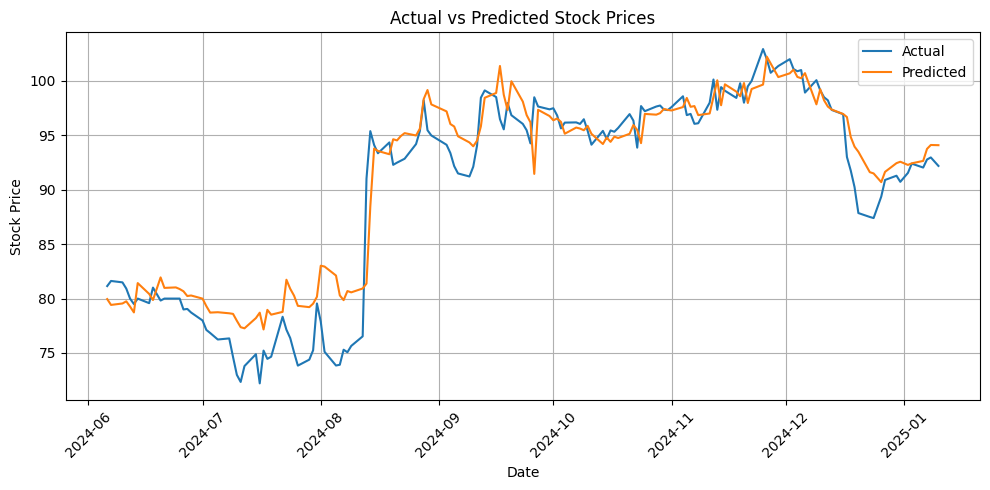

In [ ]:
# Predict on the test set
y_pred_scaled = best_model.predict(X_test_seq)

# Inverse scale the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(dates[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(dates[-len(y_pred):], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

.

#### **III. Future Prediction**

This model is designed for single-step regression. We will predict the next day stock Open price of Starbucks.

In [ ]:
# Extract the last sequence
last_sequence = X_test_scaled[-30:].reshape(1, 30, X_test_scaled.shape[1])

next_day_prediction_scaled = best_model.predict(last_sequence)

next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)
print(f"Predicted Next Day Open Price: {next_day_prediction[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Next Day Open Price: 92.66


# **References**

[1]1.17. neural network models (supervised) (no date a) scikit. Available at: https://scikit-learn.org/stable/modules/neural_networks_supervised.html (Accessed: 27 March 2025).

[2]Yahoo Finance, n.d. Starbucks historical stock data. [online] Available at: <https://finance.yahoo.com/> [Accessed 13 March. 2025].

[3]Google Finance, n.d. Starbucks Corporation (SBUX) stock. [online] Available at: <https://www.google.com/finance> [Accessed 13 March. 2025].

[4]Refinitiv Developer Community, 2020. Time Series Historical Data - LSEG Developer Community. [online] Refinitiv. Available at: <https://community.developers.refinitiv.com/discussion/103653/time-series-historical-data/p1> [Accessed 24 March. 2025].

[5]Toward Data Science, 2021. Anomaly Detection Guide. [online] Available at: <https://towardsdatascience.com/anomaly-detection-guide> [Accessed 27 March. 2025].

[6]Google Scholar, n.d. Anomaly detection in time series data. [online] Available at: <https://scholar.google.com/> [Accessed 27 March. 2025].

[7]Scikit-learn, n.d. Preprocessing data — scikit-learn 1.3.2 documentation. [online] Available at: <https://scikit-learn.org/stable/modules/preprocessing.html> [Accessed 23 March. 2025].

[8]Brownlee, J., 2020. How to Normalize and Standardize Time Series Data in Python. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com> [Accessed 24 March. 2025].

[9]Shi, Z., Hu, Y., Mo, G. and Wu, J., 2022. Attention-based CNN-LSTM and XGBoost Hybrid Model for Stock Prediction. arXiv. Available at: [https://arxiv.org/abs/2204.02623] [Accessed 10 April 2025].

[10]Kamyab, M., Liu, G. and Adjeisah, M., 2021. Attention-Based CNN and Bi-LSTM Model Based on TF-IDF and GloVe Word Embedding for Sentiment Analysis. Applied Sciences, 11(23), p.11255. Available at: [https://www.mdpi.com/2076-3417/11/23/11255] [Accessed 10 April 2025].

[11]Jiang, M., Zhang, W., Zhang, M., Wu, J. and Wen, T., 2019. An LSTM-CNN Attention Approach for Aspect-Level Sentiment Classification. Journal of Computational Methods in Sciences and Engineering, 19, pp.859–868. Available at: [https://journals.sagepub.com/doi/pdf/10.3233/JCM-190022?download=true] [Accessed 10 April 2025].

[12]Alzubaidi, L., Zhang, J., Humaidi, A.J., et al., 2021. Review of Deep Learning: Concepts, CNN Architectures, Challenges, Applications, Future Directions. Journal of Big Data, 8(53). Available at: [https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8] [Accessed 10 April 2025].

[13]Mienye, I.D. and Swart, T.G., 2024. A Comprehensive Review of Deep Learning: Architectures, Recent Advances, and Applications. Information, 15(12), p.755. Available at: [https://www.mdpi.com/2078-2489/15/12/755] [Accessed 10 April 2025].

[14]Shiri, F.M., Perumal, T., Mustapha, N. and Mohamed, R., 2024. A Comprehensive Overview and Comparative Analysis on Deep Learning Models. arXiv. Available at: [https://arxiv.org/pdf/2305.17473] [Accessed 10 April 2025]

[15]Alam, K., 2024. Enhancing Stock Market Prediction: A Robust LSTM-DNN Model Analysis on 26 Real-Life Datasets. IEEE Access. Available at: https://www.academia.edu/125433467 [Accessed 10 April 2025].

[16]Yu, P. and Yan, X., 2019. Stock price prediction based on deep neural networks. Neural Computing and Applications, 32, pp.1609–1628. Available at: https://link.springer.com/article/10.1007/s00521-019-04212-x [Accessed 10 April 2025].

[17]Dronyuk, I., Klapchuk, M. and Singh, D.S.P., 2025. Stock Market Values Prediction Using Deep Neural Networks. Advances in Computer Science for Engineering and Education VII, Lecture Notes on Data Engineering and Communications Technologies, 242, pp.239–248. Available at: https://link.springer.com/chapter/10.1007/978-3-031-84228-3_20 [Accessed 10 April 2025]

[18]3.2. tuning the hyper-parameters of an estimator (no date) scikit. Available at: https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator (Accessed: 03 March 2025).